[*********************100%%**********************]  1 of 1 completed
C:\Users\14253\AppData\Local\Temp\ipykernel_16888\430957839.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date'] = pd.to_datetime(X['Date']).map(pd.Timestamp.timestamp)


Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training RMSE: 1.7622602430075456
Testing RMSE: 4.403916255084985


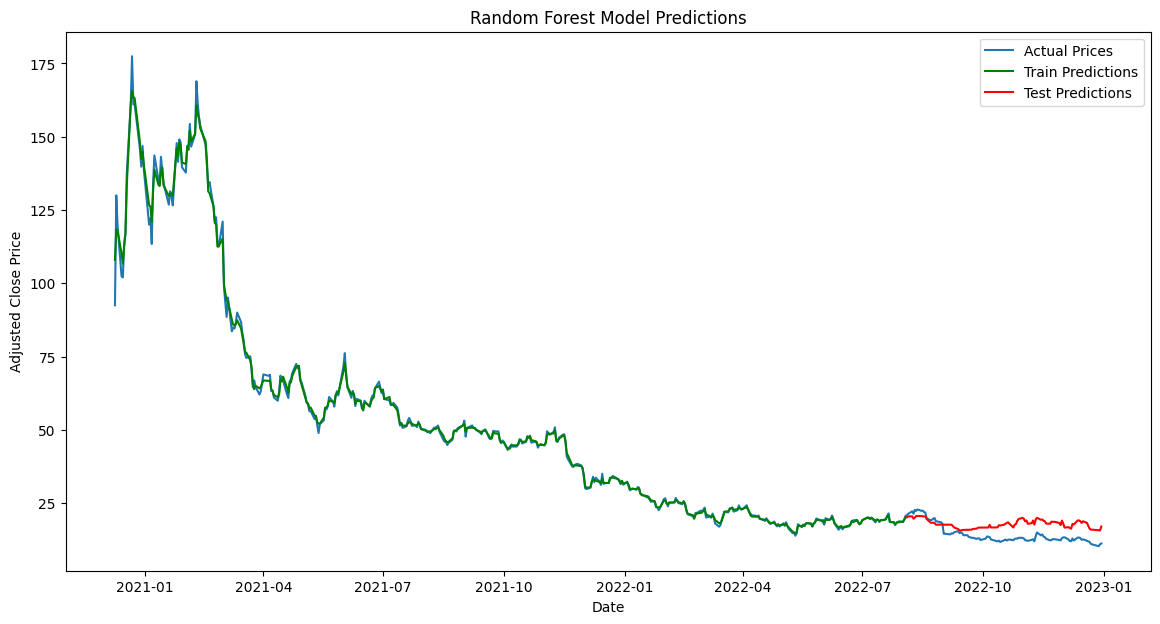

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


ticker = 'AI'  
start_date = '2020-01-01'
end_date = '2023-01-01'
asset_data = yf.download(ticker, start=start_date, end=end_date)


asset_data.reset_index(inplace=True)


def compute_RSI(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_MACD(series, short_period=12, long_period=26, signal_period=9):
    short_ema = series.ewm(span=short_period, adjust=False).mean()
    long_ema = series.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd - signal

asset_data['MA20'] = asset_data['Adj Close'].rolling(window=20).mean()
asset_data['MA50'] = asset_data['Adj Close'].rolling(window=50).mean()
asset_data['RSI'] = compute_RSI(asset_data['Adj Close'])
asset_data['MACD'] = compute_MACD(asset_data['Adj Close'])


asset_data.fillna(method='bfill', inplace=True)


X = asset_data[['Date', 'MA20', 'MA50', 'RSI', 'MACD']]
y = asset_data['Adj Close']


X['Date'] = pd.to_datetime(X['Date']).map(pd.Timestamp.timestamp)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


split_index = int(len(X) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f'Best Params: {grid_search.best_params_}')
print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')


plt.figure(figsize=(14, 7))
plt.plot(asset_data['Date'], y, label='Actual Prices')
plt.plot(asset_data['Date'][:len(y_train)], y_train_pred, label='Train Predictions', color='green')
plt.plot(asset_data['Date'][len(y_train):], y_test_pred, label='Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Random Forest Model Predictions')
plt.legend()
plt.show()
